### Rednering

In [2]:
import os,glfw
import numpy as np
import matplotlib.pyplot as plt
import mujoco
import mujoco_viewer
np.set_printoptions(precision=2,suppress=True,linewidth=100)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
print ("MuJoCo version:[%s]"%(mujoco.__version__))

MuJoCo version:[2.3.2]


### Util

In [3]:
def rpy2r(rpy):
    """
        roll,pitch,yaw in radian to R
    """
    roll  = rpy[0]
    pitch = rpy[1]
    yaw   = rpy[2]
    Cphi  = np.math.cos(roll)
    Sphi  = np.math.sin(roll)
    Cthe  = np.math.cos(pitch)
    Sthe  = np.math.sin(pitch)
    Cpsi  = np.math.cos(yaw)
    Spsi  = np.math.sin(yaw)
    R     = np.array([
        [Cpsi * Cthe, -Spsi * Cphi + Cpsi * Sthe * Sphi, Spsi * Sphi + Cpsi * Sthe * Cphi],
        [Spsi * Cthe, Cpsi * Cphi + Spsi * Sthe * Sphi, -Cpsi * Sphi + Spsi * Sthe * Cphi],
        [-Sthe, Cthe * Sphi, Cthe * Cphi]
    ])
    assert R.shape == (3, 3)
    return R
print ("Ready.")

Ready.


### Parse `UR5e`

In [4]:
xml_path='../model/ur5e/ur5.xml'
full_xml_path = os.path.abspath(os.path.join(os.getcwd(),xml_path))
model = mujoco.MjModel.from_xml_path(full_xml_path)
data = mujoco.MjData(model)
print ("[UR5e] parsed.")

[Panda] parsed.


In [5]:
n_body          = model.nbody # number of bodies
body_names      = [mujoco.mj_id2name(model,mujoco.mjtObj.mjOBJ_BODY,x) for x in range(n_body)]
n_joint         = model.njnt     # number of joints
joint_names     = [mujoco.mj_id2name(model,mujoco.mjtJoint.mjJNT_HINGE,x) for x in range(n_joint)]
joint_types     = model.jnt_type # joint types
joint_ranges    = model.jnt_range # joint ranges
rev_joint_idxs  = np.where(joint_types==mujoco.mjtJoint.mjJNT_HINGE)[0].astype(np.int32)
rev_joint_names = [joint_names[x] for x in rev_joint_idxs]
n_rev_joint     = len(rev_joint_idxs)
rev_joint_min   = joint_ranges[rev_joint_idxs,0]
rev_joint_max   = joint_ranges[rev_joint_idxs,1]
rev_joint_range = rev_joint_max - rev_joint_min
pri_joint_idxs  = np.where(joint_types==mujoco.mjtJoint.mjJNT_SLIDE)[0].astype(np.int32)
pri_joint_names = [joint_names[x] for x in pri_joint_idxs]
n_pri_joint     = len(pri_joint_idxs)
# Print
print ("n_body:[%d]"%(n_body))
print ("body_names:%s"%(body_names))
print ("n_joint:[%d]"%(n_joint))
print ("joint_names:%s"%(joint_names))
print ("joint_types:%s"%(joint_types))
print ("joint_ranges:\n%s"%(joint_ranges))
print ("n_rev_joint:[%d]"%(n_rev_joint))
print ("rev_joint_idxs:%s"%(rev_joint_idxs))
print ("rev_joint_names:%s"%(rev_joint_names))
print ("rev_joint_min:%s"%(rev_joint_min))
print ("rev_joint_max:%s"%(rev_joint_max))
print ("rev_joint_range:%s"%(rev_joint_range))
print ("n_pri_joint:[%d]"%(n_pri_joint))
print ("pri_joint_idxs:%s"%(pri_joint_idxs))
print ("pri_joint_names:%s"%(pri_joint_names))

n_body:[19]
body_names:['world', 'box_link', 'ur_base_link', 'ur_shoulder_link', 'ur_upper_arm_link', 'ur_forearm_link', 'ur_wrist_1_link', 'ur_wrist_2_link', 'ur_wrist_3_link', 'ur_tcp_link', 'camera_mount', 'ur_rg2_gripper_base_link', 'rg2_gripper_finger1_finger_link', 'rg2_gripper_finger1_inner_knuckle_link', 'rg2_gripper_finger1_finger_tip_link', 'rg2_gripper_finger2_finger_link', 'rg2_gripper_finger2_inner_knuckle_link', 'rg2_gripper_finger2_finger_tip_link', 'base']
n_joint:[7]
joint_names:['ur_shoulder_pan_joint', 'ur_shoulder_lift_joint', 'ur_elbow_joint', 'ur_wrist_1_joint', 'ur_wrist_2_joint', 'ur_wrist_3_joint', 'ur_tcp_joint']
joint_types:[3 3 3 3 3 3 3]
joint_ranges:
[[-3.14  3.14]
 [-3.14  3.14]
 [-3.14  3.14]
 [-3.14  3.14]
 [-3.14  3.14]
 [-3.14  3.14]
 [-3.14  3.14]]
n_rev_joint:[7]
rev_joint_idxs:[0 1 2 3 4 5 6]
rev_joint_names:['ur_shoulder_pan_joint', 'ur_shoulder_lift_joint', 'ur_elbow_joint', 'ur_wrist_1_joint', 'ur_wrist_2_joint', 'ur_wrist_3_joint', 'ur_tcp_join

### Render with different markers

In [6]:
def add_coordiate_axes(viewer,p,R,axis_len=1.0,axis_width=0.01,label=''):
    """
        Plot coordinate axes
    """
    rgba_x = [1.0,0.0,0.0,0.9]
    rgba_y = [0.0,1.0,0.0,0.9]
    rgba_z = [0.0,0.0,1.0,0.9]
    # X axis
    R_x = R@rpy2r(np.deg2rad([0,0,90]))@rpy2r(np.pi/2*np.array([1,0,0]))
    p_x = p + R_x[:,2]*axis_len/2
    viewer.add_marker(
        pos   = p_x,
        type  = mujoco.mjtGeom.mjGEOM_CYLINDER,
        size  = [axis_width,axis_width,axis_len/2],
        mat   = R_x,
        rgba  = rgba_x,
        label = ''
    )
    R_y = R@rpy2r(np.deg2rad([0,0,90]))@rpy2r(np.pi/2*np.array([0,1,0]))
    p_y = p + R_y[:,2]*axis_len/2
    viewer.add_marker(
        pos   = p_y,
        type  = mujoco.mjtGeom.mjGEOM_CYLINDER,
        size  = [axis_width,axis_width,axis_len/2],
        mat   = R_y,
        rgba  = rgba_y,
        label = ''
    )
    R_z = R@rpy2r(np.deg2rad([0,0,90]))@rpy2r(np.pi/2*np.array([0,0,1]))
    p_z = p + R_z[:,2]*axis_len/2
    viewer.add_marker(
        pos   = p_z,
        type  = mujoco.mjtGeom.mjGEOM_CYLINDER,
        size  = [axis_width,axis_width,axis_len/2],
        mat   = R_z,
        rgba  = rgba_z,
        label = ''
    )
    viewer.add_marker(
            pos   = p,
            size  = [0.001,0.001,0.001],
            rgba  = [1.0,1.0,1.0,1.0],
            type  = mujoco.mjtGeom.mjGEOM_SPHERE,
            label = label)
print ("Ready.")

Ready.


In [16]:
# Viewer
viewer = mujoco_viewer.MujocoViewer(model,data,mode='window',
    title='UR in MuJoCo',width=1200,height=800,hide_menus=True)
viewer.cam.azimuth   = 80
viewer.cam.distance  = 2.0
viewer.cam.elevation = -30
viewer.cam.lookat = np.array([0,0,1.2])
# simulate and render
mujoco.mj_resetData(model, data)
mujoco.mj_forward(model, data)
dt = model.opt.timestep
nstep = 5
# Buffers
tick = 0
max_time = 100 # (second)
imgs,img_ticks = [],[]
while data.time < max_time:
    tick = tick + 1
    if viewer.is_alive:
        # Update
        mujoco.mj_step(model,data,nstep=nstep)
        # Add sphere
        viewer.add_marker(
            pos   = data.body('ur_rg2_gripper_base_link').xpos,
            size  = [0.05,0.05,0.05],
            rgba  = [1,0,0,0.3],
            type  = mujoco.mjtGeom.mjGEOM_SPHERE,
            label = 'EE')
        # Add coordiate axes
        add_coordiate_axes(viewer,p=np.zeros(3),R=np.eye(3,3),
                           axis_len=1.0,axis_width=0.01,label='')
        add_coordiate_axes(viewer,
                           p = data.body('ur_rg2_gripper_base_link').xpos,
                           R = data.body('ur_rg2_gripper_base_link').xmat.reshape([3,3]),
                           axis_len=0.5,axis_width=0.01,label='')
        # Add an arrow
        viewer.add_marker(
            pos   = data.body('ur_rg2_gripper_base_link').xpos,
            mat   = data.body('ur_rg2_gripper_base_link').xmat.reshape([3,3]),
            type  = mujoco.mjtGeom.mjGEOM_ARROW,
            size  = [0.05,0.05,1.0],
            rgba  = [0,0,1,1],
            label = ''
        )
        # Render
        viewer.render()
    else: break # terminate if viewer is dead
    # Grab image
    every_second = 1 # (second)
    if (tick % int(every_second/dt/nstep)) == 0:
        img = np.zeros((viewer.viewport.height,viewer.viewport.width,3),dtype=np.uint8)
        mujoco.mjr_render(viewer.viewport, viewer.scn, viewer.ctx)
        mujoco.mjr_readPixels(img, None, viewer.viewport, viewer.ctx) # this makes a little delay
        img = np.flipud(img) # flip image
        imgs.append(img)
        img_ticks.append(tick)
# close viewer
viewer.close() 
print ("tick:[%d] [%.2f]sec. Done."%(tick,data.time))

Pressed ESC
Quitting.
tick:[897] [8.96]sec. Done.


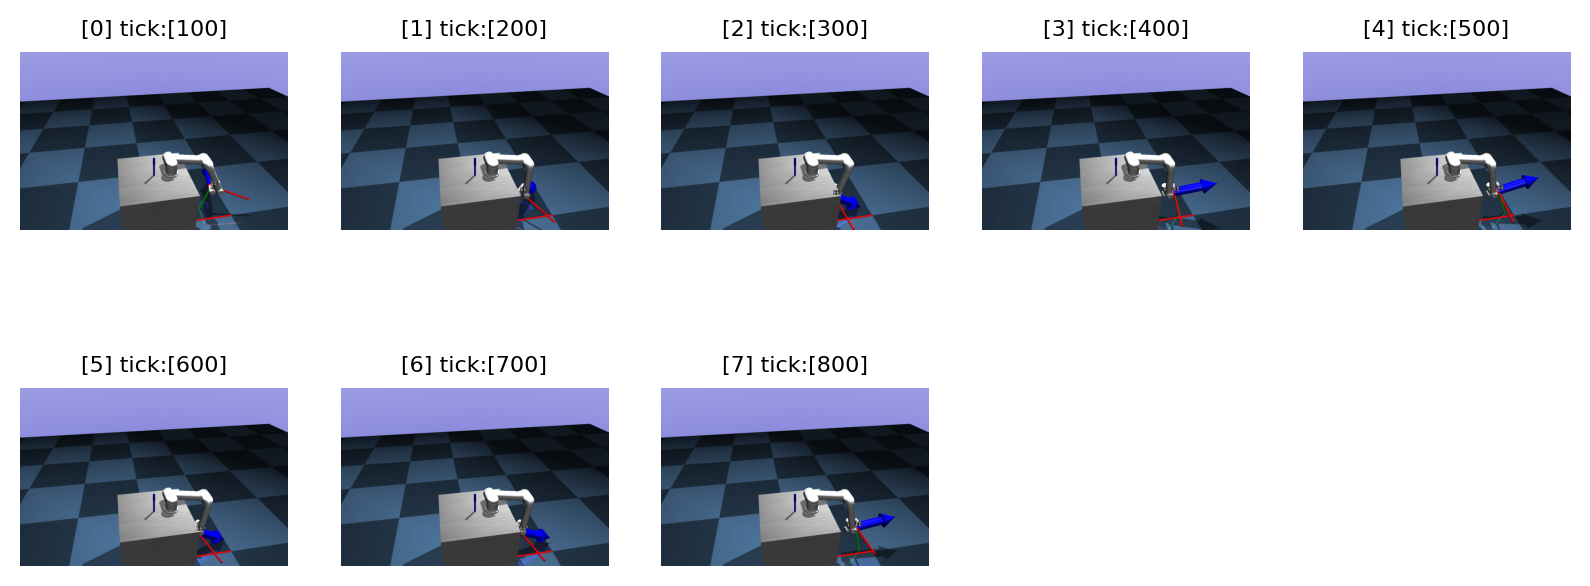

In [17]:
# Plot UR5e
fig = plt.figure(figsize=(10,4))
for i_idx,img in enumerate(imgs):
    ax = fig.add_subplot(len(imgs)//5+1,5,i_idx+1)
    ax.imshow(img)
    ax.set_title('[%d] tick:[%d]'%(i_idx,img_ticks[i_idx]),fontsize=8)
    ax.axis('off')

### Move camera view

In [21]:
# Viewer
viewer = mujoco_viewer.MujocoViewer(model,data,mode='window',
    title='UR in MuJoCo',width=1200,height=800,hide_menus=True)
viewer.cam.azimuth   = 80
viewer.cam.distance  = 2.0
viewer.cam.elevation = -30
viewer.cam.lookat = np.array([0,0,1.2])
# simulate and render
mujoco.mj_resetData(model, data)
mujoco.mj_forward(model, data)
dt = model.opt.timestep
nstep = 5
# Buffers
tick = 0
max_time = 10 # (second)
imgs,img_ticks = [],[]
while data.time < max_time:
    tick = tick + 1
    if viewer.is_alive:
        # Change render view
        viewer.cam.azimuth  = 90 + 0.2*tick
        viewer.cam.distance = 1.0 + 0.01*tick
        
        # Update
        mujoco.mj_step(model,data,nstep=nstep)
        # Add sphere
        viewer.add_marker(
            pos   = data.body('ur_rg2_gripper_base_link').xpos,
            size  = [0.05,0.05,0.05],
            rgba  = [1,0,0,0.3],
            type  = mujoco.mjtGeom.mjGEOM_SPHERE,
            label = 'EE')
        # Add coordiate axes
        add_coordiate_axes(viewer,p=np.zeros(3),R=np.eye(3,3),
                           axis_len=1.0,axis_width=0.01,label='')
        add_coordiate_axes(viewer,
                           p = data.body('ur_rg2_gripper_base_link').xpos,
                           R = data.body('ur_rg2_gripper_base_link').xmat.reshape([3,3]),
                           axis_len=0.5,axis_width=0.01,label='')
        # Add an arrow 
        viewer.add_marker(
            pos   = data.body('ur_rg2_gripper_base_link').xpos,
            mat   = data.body('ur_rg2_gripper_base_link').xmat.reshape([3,3]),
            type  = mujoco.mjtGeom.mjGEOM_ARROW,
            size  = [0.05,0.05,1.0],
            rgba  = [0,0,1,1],
            label = ''
        )
        # Render
        viewer.render()
    else: break # terminate if viewer is dead
    # Grab image
    every_second = 1 # (second)
    if (tick % int(every_second/dt/nstep)) == 0:
        img = np.zeros((viewer.viewport.height,viewer.viewport.width,3),dtype=np.uint8)
        mujoco.mjr_render(viewer.viewport, viewer.scn, viewer.ctx)
        mujoco.mjr_readPixels(img, None, viewer.viewport, viewer.ctx) # this makes a little delay
        img = np.flipud(img) # flip image
        imgs.append(img)
        img_ticks.append(tick)
# close viewer
viewer.close()
print ("tick:[%d] [%.2f]sec. Done."%(tick,data.time))

tick:[1000] [10.00]sec. Done.


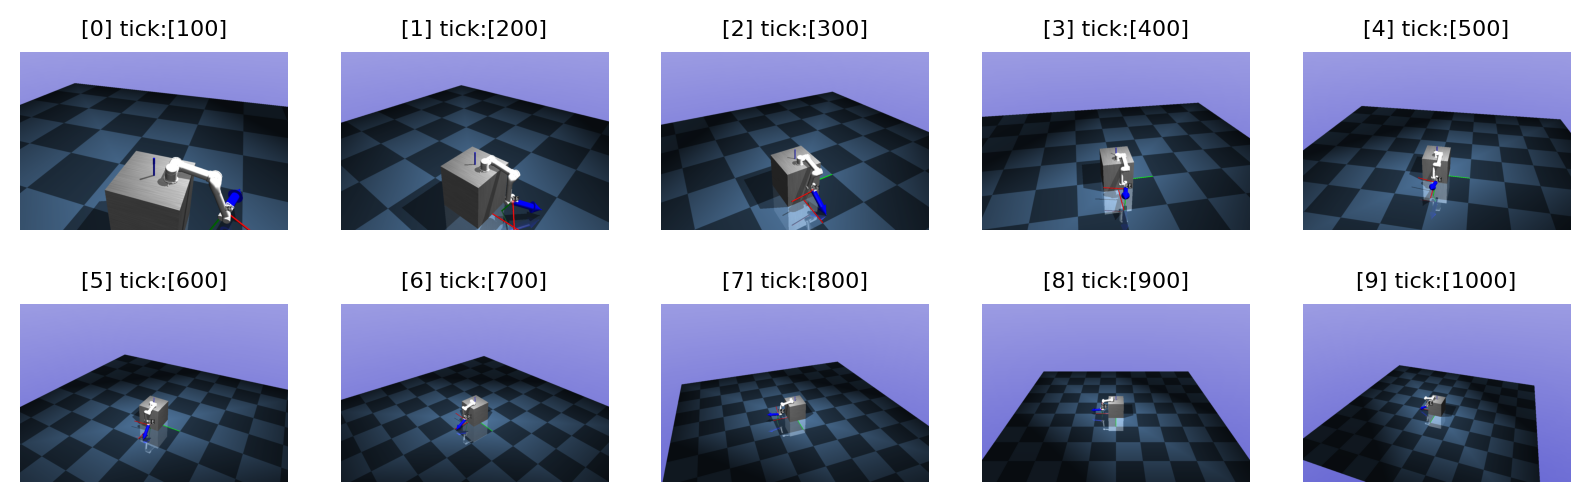

In [22]:
# Plot UR
fig = plt.figure(figsize=(10,3))
for i_idx,img in enumerate(imgs):
    ax = fig.add_subplot(2,5,i_idx+1)
    ax.imshow(img)
    ax.set_title('[%d] tick:[%d]'%(i_idx,img_ticks[i_idx]),fontsize=8)
    ax.axis('off')